In [3]:
%matplotlib ipympl 

#import sys
#sys.path.insert(1, '/project/f/fherwig/fherwig/PythonVirtual/NuGridPy')

import numpy as np
from matplotlib import pyplot as plt

from nugridpy import nugridse as nuse
from nugridpy import utils

import os
import sys
import contextlib
import pandas as pd

import h5py

from matplotlib import colors as mcolors
from matplotlib.ticker import MaxNLocator

from astropy import constants as const
from astropy import units as u

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

# important feature!
from multizone import mppnp_reader

In [4]:
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


In [21]:
def get_sol_abu(isotopes):    

    def get_sol(sol_ab="/data/niagara_project/projects/ocmerger_issa2025/CONDITIONS/iniab2.0E-02GN93.ppn"):
        '''
            grab the solar abundances and turn it into a dataframe
        '''
            
        f = open(sol_ab, 'r')
    
        sol_iso_z=[]
        sol_iso=[]
        sol_iso_name = []
        sol_iso_a = []
        sol_iso_abu=[]
    
        for line in f:
            n = len(line.split())
            if n == 3:
                sol_iso = line.split()[1]
                if sol_iso == 'PROT':
                    sol_iso_name.append('h')
                    sol_iso_a.append(1)
                    sol_iso_z.append(int(line.split()[0]))
                    sol_iso_abu.append(float(line.split()[2]))
                else:
                    sol_iso_name.append(sol_iso[0:2])
                    sol_iso_a.append(int(sol_iso[2:5]))
                    sol_iso_z.append(int(line.split()[0]))
                    sol_iso_abu.append(float(line.split()[2]))
            if n == 4:
                sol_iso_z.append(int(line.split()[0]))
                sol_iso_name.append(line.split()[1])
                sol_iso_a.append(int(line.split()[2]))
                sol_iso_abu.append(float(line.split()[3]))
    
        f.close()
    
        df_solar = pd.DataFrame()
        df_solar['Z'] = sol_iso_z
        df_solar['Element'] = sol_iso_name
        df_solar['sol_iso_a'] = sol_iso_a
        df_solar['sol_iso_abu'] = sol_iso_abu
        
        return df_solar

    df_solar = get_sol()
    
    if type(isotopes) == str:
        
        ele, num = isotopes.split('-')
        
        elemask = df_solar.Element == ele.lower()
                
        nummask = df_solar.sol_iso_a == int(num)
        
        mask = elemask & nummask
        
        abu = df_solar[mask].sol_iso_abu.to_numpy()[0]
        
        return abu
    
    else:
        res = []
        for iso in isotopes:
            ele, num = iso.split('-')
        
            elemask = df_solar.Element == ele.lower()

            nummask = df_solar.sol_iso_a == int(num)

            mask = elemask & nummask
            
            abu = df_solar[mask].sol_iso_abu.to_numpy()[0]
            res.append(abu)
            
        return np.array(res)

In [22]:
def get_everything_you_need(mixing_case, sub_case="7.95E+03"):
    # the initial abundances for NOVA models are the Asplund et al. (2009) solar abundances 
    #upper = "/user/niagara_scratch_fherwig/wendi.user/jissa/mixing_results/"
    upper = "/data/niagara_project/projects/ocmerger_issa2025/RUNS/"
    if mixing_case != "GOSH": mppnp_test_dir=upper + f"{mixing_case}_RUNS/hif{sub_case}/H5_surf/"
    else: mppnp_test_dir=upper + f"{mixing_case}_RUNS/{sub_case}/H5_surf/"
    
    sol_ab=upper+"../CONDITIONS/iniab2.0E-02GN93.ppn"
    
    init_ab=sol_ab
    
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)

    # read in initial elemental abundances in the path init_ab
    utils.solar(init_ab,1.)
    init_abu=utils.solar_elem_abund
    n_init=len(init_abu)
    #print ("\nn_init =",n_init)

    # read in solar abundances in the path sol_ab
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)
    #print ("\nn_sol =",n_sol)
    
    # initial and solar abundances do not include Tc and Pm
    # here we include them with the abundances 1e-99
    
    n_el = n_sol + 2  # n_sol + the unstable Tc (Z=43) and Pm (Z=61)
    
    el_name=["  " for x in range(n_el)]
    
    z_el=np.linspace(0,0,n_el)
    
    el_name[0]='n'
    for i in range(n_el):
        z_el[i]=float(i)       #  Z=i in mppnp surf data output
        if (i>0):
            el_name[i]=utils.get_el_from_z(i)
    
    # el_abu_init = np.linspace(1e-99,1e-99,n_el)
    el_abu_sol = np.linspace(1e-99,1e-99,n_el)
    
    for i in range(n_el):  
        for k in range(n_sol):
            z_sol=k+1
            if float(z_sol)==z_el[i] and z_sol != 43 and z_sol != 61:  
    #             el_abu_init[i] = init_abu[k]
                el_abu_sol[i] = sol_abu[k]
    
    # print ("X_init =",el_abu_init[1],", X_init(Tc) =", el_abu_init[43],", X_init(Pm) =", el_abu_init[61])
    #print ("X_sol =",el_abu_sol[1],", X_sol(Tc) =", el_abu_sol[43],", X_sol(Pm) =", el_abu_sol[61])

    work_dir = mppnp_test_dir

    model = 11200
    
    mc = 0 
    h5_file = work_dir + "my_test_hif.0010001.surf.h5"
    
    #print("Zero variation case:", h5_file)
    with h5py.File(h5_file, 'r') as file:
        dset = file["/cycle"+str(model).zfill(10)+"/SE_DATASET"]
        el_abu_0 = dset['elem_massf_decay'][0]
        iso_abu_0 = dset['iso_massf_decay'][0]

    
        n_iso = len(iso_abu_0)
        iso_z=np.linspace(0,0,n_iso)
        iso_a=np.linspace(0,0,n_iso)
        iso_name=["  " for x in range(n_iso)]

        iso_name[0] = 'n'
        iso_name[1] = 'H'
        
        dseta = file["A"]
        dsetz = file["Z"]
        iso_a[:] = dseta[:]
        iso_z[:] = dsetz[:]

    
    isomers = ['ALm', 'KRm', 'CDm', 'LUm', 'TAm']
    start = n_iso - len(isomers)
    for isomer in isomers: 
        i = isomers.index(isomer)
        iso_name[start+i] = isomer
    
    for i in range(2,n_iso-len(isomers)):
        iz = int(iso_z[i])
        iso_name[i] = utils.get_el_from_z(int(iso_z[i]))
        
    iso_full_name = []
    for i in range(n_iso):
        iso_full_name.append(iso_name[i]+"-"+str(int(iso_a[i])))
    
    return el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_full_name

In [23]:
aesthetics = {"MLT": 
                  {"markers": ['^', 'D','s','o'],
                   "colours": ['midnightblue','blue','cornflowerblue','tab:blue'],
                   "case_label": "MLT",
                   "linestyle": "solid",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
              
              "PPM":
                  {"markers": ['^', 'o','s','D'],
                   "colours": ['darkorange','chocolate','orange','tab:orange'],
                   "case_label": r"$D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "dashed",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
              
              "PPM3":
                  {"markers": ['^', 'o','D','s'],
                   "colours": ['darkgreen','seagreen','lime','tab:green'],
                   "case_label": r"$3\times D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "dotted",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},

              "PPM10":
                  {"markers": ['s', 'o','D','^'],
                   "colours": ['darkred','firebrick','indianred','tab:red'],
                   "case_label": r"$10\times D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "solid",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
             
              "PPM50":
                  {"markers": ['s', 'o','D','v'],
                   "colours": ['rebeccapurple','mediumorchid','plum','tab:purple'],
                   "case_label": r"$50\times D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "dashed",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
              
              "GOSH":
                  {"markers": ['D', 's', '^', 'v'],
                   "colours": ['tab:pink','lime','tab:brown','mediumturquoise'],
                   "case_label": "Quenched",
                   "linestyle": "dotted",
                   "folders": ["gosh", "gosh_stronger", "partial_merger", "partial_merger_stronger"],
                   "ilabs": ["GOSH-like", "Stronger GOSH-like", "Partial Merger", "Stronger Partial Merger"]
                  }
              

}

In [31]:
def plot_elemental_and_isotopic_ratios(ifig, stuff1, stuff2, mixing_cases, sub_category="", as_scatter=True, find_powerlaw=False):
    
    def format_iso(x):
        if x.find('-') != - 1:
            ele, A = x.split('-')
            return rf'$^{{{A}}}\mathrm{{{ele}}}$'
        else:
            return x

    plt.close(ifig); plt.figure(ifig, figsize=(6, 4))

    top1, bot1 = format_iso(stuff1[0]), format_iso(stuff1[1])
    top2, bot2 = format_iso(stuff2[0]), format_iso(stuff2[1])    
        
    xaxislabel = "["+f"{top2}/{bot2}"+"]"
    yaxislabel = "["+f"{top1}/{bot1}"+"]"

    all_xs, all_ys = [], []  # Accumulate all points across all cases and folders

    for case in mixing_cases:

        aes = aesthetics[case]

        if sub_category == "":
            cidxs = [3]
        elif sub_category == "all":
            cidxs = [0, 1, 2, 3]
        else:
            cidxs = [aes["folders"].index(sub_category)]
            
        plt_xs, plt_ys = [], []
        for cidx in cidxs:
            with suppress_stdout():
                el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need(case, aes["folders"][cidx])

            
            Xs1, Xs2, Xsol1, Xsol2 = [], [], [], []
            for thing in stuff1:
                if thing.find('-') == -1:
                    idxs1 = el_name.index(thing)
                    Xs1.append(el_abu_0[idxs1])
                    Xsol1.append(el_abu_sol[idxs1])
                else:
                    idxs1 = iso_name.index(thing)
                    Xs1.append(iso_abu_0[idxs1])
                    Xsol1.append(get_sol_abu(thing))
                    
            for thing in stuff2:
                if thing.find('-') == -1:
                    idxs2 = el_name.index(thing)
                    Xs2.append(el_abu_0[idxs2])
                    Xsol2.append(el_abu_sol[idxs2])
                else:
                    idxs2 = iso_name.index(thing)
                    Xs2.append(iso_abu_0[idxs2])
                    Xsol2.append(get_sol_abu(thing))

            ratio1 = np.log10(Xs1[0]/Xs1[1]) - np.log10(Xsol1[0]/Xsol1[1])
            ratio2 = np.log10(Xs2[0]/Xs2[1]) - np.log10(Xsol2[0]/Xsol2[1])

            all_xs.append(ratio2)
            all_ys.append(ratio1)
            
            plt_xs.append(ratio2)
            plt_ys.append(ratio1)

            if as_scatter:
                if len(mixing_cases) == 1:
                    label = aes["ilabs"][cidx]
                else:
                    label = aes["case_label"] + f' ({aes["ilabs"][cidx]})'

                plt.scatter(ratio2, ratio1, color=aes["colours"][cidx], marker=aes["markers"][cidx], label=label, alpha=0.8, zorder=2, s=40)

        if not as_scatter:
            plt.plot(plt_xs, plt_ys, color=aes["colours"][3], label=aes["case_label"], alpha=0.8, linestyle=aes["linestyle"], zorder=2, lw=2)

    if find_powerlaw and len(all_xs) > 1:
        xs_np = np.array(all_xs)
        ys_np = np.array(all_ys)

        coeffs = np.polyfit(xs_np, ys_np, 1)
        m, b = coeffs
        m_str = f"{m:.2g}"
        b_str = f"{b:.2g}"
        label = f"{yaxislabel} = {m_str}{xaxislabel}" + f"${b_str if b < 0 else '+'+b_str}$"

        xfit = np.linspace(min(xs_np), max(xs_np), 100)
        yfit = m * xfit + b

        plt.plot(xfit, yfit, color='black', linestyle='--', lw=2, label=label, zorder=1)

    #plt.legend(fancybox=True, fontsize=12)
    plt.xlabel(xaxislabel, fontsize=14)
    plt.ylabel(yaxislabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axhline(0, color='dimgray', zorder=0, lw=2, alpha=0.5)
    plt.axvline(0, color='dimgray', zorder=0, lw=2, alpha=0.5)
    plt.tight_layout()

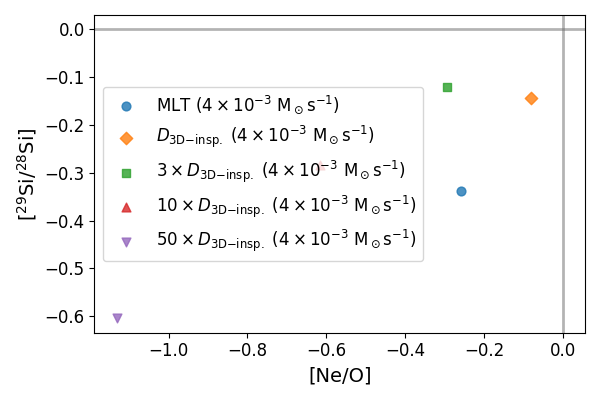

In [25]:
plot_elemental_and_isotopic_ratios(1, ["Si-29", "Si-28"], ["Ne", "O"], ["MLT", "PPM", "PPM3", "PPM10", "PPM50"])

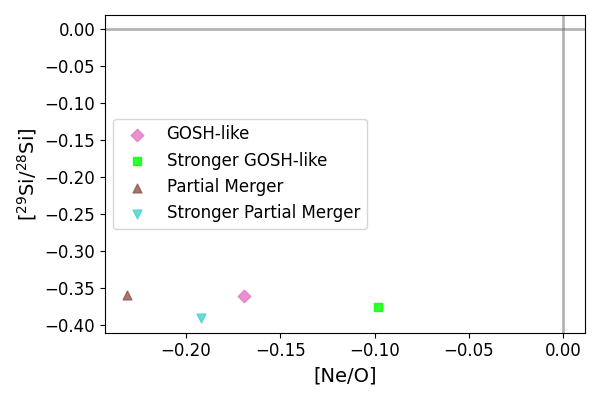

In [26]:
plot_elemental_and_isotopic_ratios(2, ["Si-29", "Si-28"], ["Ne", "O"], ["GOSH"], "all")

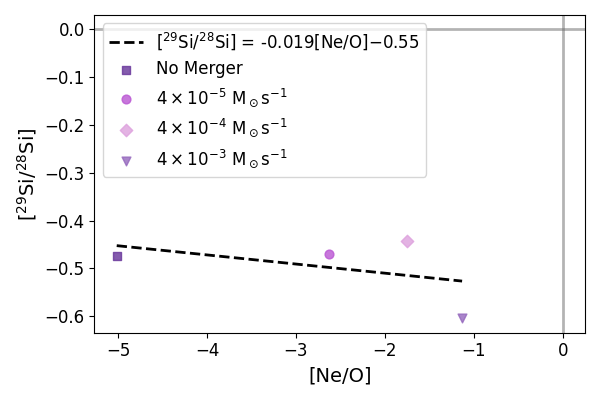

In [28]:
plot_elemental_and_isotopic_ratios(3, ["Si-29", "Si-28"], ["Ne", "O"], ["PPM50"], "all", find_powerlaw=True)

#plt.savefig("ingestion_lightoddZ.pdf")

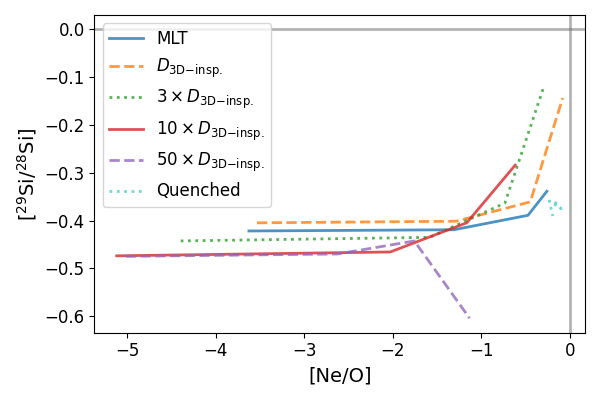

In [29]:
plot_elemental_and_isotopic_ratios(4, ["Si-29", "Si-28"], ["Ne", "O"], ["MLT", "PPM", "PPM3", "PPM10", "PPM50", "GOSH"], "all", as_scatter=False)

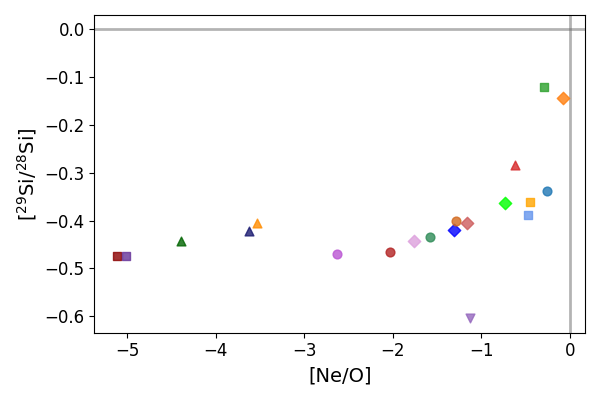

In [32]:
plot_elemental_and_isotopic_ratios(4, ["Si-29", "Si-28"], ["Ne", "O"], ["MLT", "PPM", "PPM3", "PPM10", "PPM50"], "all", as_scatter=True)

In [39]:
stuff1, stuff2 = ["Si-29", "Si-28"], ["Ne", "O"]

sub_category = "all"

si29, si28 = [], []

for case in ["MLT", "PPM", "PPM3", "PPM10", "PPM50"]:

    aes = aesthetics[case]

    if sub_category == "":
        cidxs = [3]
    elif sub_category == "all":
        cidxs = [0, 1, 2, 3]
    else:
        cidxs = [aes["folders"].index(sub_category)]

    for cidx in cidxs:
        with suppress_stdout():
            el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need(case, aes["folders"][cidx])


        Xs1, Xs2, Xsol1, Xsol2 = [], [], [], []
        for thing in stuff1:
            if thing.find('-') == -1:
                idxs1 = el_name.index(thing)
                Xs1.append(el_abu_0[idxs1])
                Xsol1.append(el_abu_sol[idxs1])
            else:
                idxs1 = iso_name.index(thing)
                Xs1.append(iso_abu_0[idxs1])
                Xsol1.append(get_sol_abu(thing))

        for thing in stuff2:
            if thing.find('-') == -1:
                idxs2 = el_name.index(thing)
                Xs2.append(el_abu_0[idxs2])
                Xsol2.append(el_abu_sol[idxs2])
            else:
                idxs2 = iso_name.index(thing)
                Xs2.append(iso_abu_0[idxs2])
                Xsol2.append(get_sol_abu(thing))
        
        si29.append(Xs1[0])
        si28.append(Xs1[1])

In [43]:
si28, si29 = np.array(si28), np.array(si29)

In [44]:

ratio = si29 / si28

mlt, ppm, ppm3, ppm10, ppm50 = ratio[:4], ratio[4:8], ratio[8:12], ratio[12:16], ratio[16:]

In [45]:
mlt, ppm, ppm3, ppm10, ppm50

(array([0.01992375, 0.020042  , 0.02148503, 0.02411983]),
 array([0.02072282, 0.02088015, 0.02292309, 0.03779788]),
 array([0.01899099, 0.01932172, 0.02279406, 0.03989672]),
 array([0.01767742, 0.01800842, 0.02073188, 0.02736052]),
 array([0.0176314 , 0.01783419, 0.01898795, 0.013085  ]))

In [47]:
data = np.vstack((mlt, ppm, ppm3, ppm10, ppm50))
data

array([[0.01992375, 0.020042  , 0.02148503, 0.02411983],
       [0.02072282, 0.02088015, 0.02292309, 0.03779788],
       [0.01899099, 0.01932172, 0.02279406, 0.03989672],
       [0.01767742, 0.01800842, 0.02073188, 0.02736052],
       [0.0176314 , 0.01783419, 0.01898795, 0.013085  ]])

In [50]:
np.mean(data[:,0]), np.mean([mlt[0], ppm[0], ppm3[0], ppm10[0], ppm50[0]])

(0.018989274218433307, 0.018989274218433307)

In [52]:
np.mean(data[1,:]), np.mean(ppm)

(0.02558098631639074, 0.02558098631639074)

In [54]:
np.mean(data, axis=0), np.mean(data, axis=1)

(array([0.01898927, 0.0192173 , 0.0213844 , 0.02845199]),
 array([0.02139265, 0.02558099, 0.02525087, 0.02094456, 0.01688463]))

In [62]:
(np.max(data, axis=0)) - (np.min(data, axis=0))

array([0.00309142, 0.00304596, 0.00393514, 0.02681172])

In [63]:
(np.max(data, axis=1)) - (np.min(data, axis=1))

array([0.00419608, 0.01707506, 0.02090573, 0.0096831 , 0.00590295])

In [68]:
aesthetics[case]["folders"]

['0.00E+00', '7.95E+01', '7.95E+02', '7.95E+03']

In [76]:
xs_full, ys_full = [], []

comps = []

i, j = 0, 0
for case in list(aesthetics.keys()):
    
    for ing in list(aesthetics[case]["folders"]):
        
        with suppress_stdout():
            el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need(case, ing)

            
        si28 = iso_abu_0[iso_name.index("Si-28")]
        si29 = iso_abu_0[iso_name.index("Si-29")]
        
        comps.append(si29/si28)

        xs_full.append(i)
        ys_full.append(j)
        
        

        i += 1
        
        if i == 4: 
            i = 0
            j += 1
        
comps = np.log10(np.array(comps))

round(np.min(comps), 4), round(np.max(comps), 4), round(np.median(comps), 4)

(-1.8832, -1.3991, -1.6818)

In [74]:
from matplotlib import colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable

def scale_size(value, minval, maxval, min_size=1, max_size=50, centre=0):

    abs_cent_value = np.abs(value - centre)
    
    normalize = np.max([np.abs(maxval-centre), np.abs(minval-centre)])
    
    normalized_value = abs_cent_value / normalize
    
    return normalized_value * (max_size - min_size) + min_size

def get_color(value, minFij, maxFij, cmap=plt.cm.jet, get='color'):
    '''Sets the colour bar scale.
    '''

    
    def set_scale():
        norm = mcolors.Normalize(vmin=minFij, vmax=maxFij)

        return norm

    norm = set_scale()
    
    if get == 'color':
        normalized_values = norm(value)

        rgba_colors = cmap(normalized_values)
        if type(rgba_colors) != type(np.array): rgba_colors = np.array(rgba_colors)
        rgba_colors[value < minFij, 3] = 0  # turn off if under minFij

        return rgba_colors
    
    elif get == 'map':
        return norm, cmap


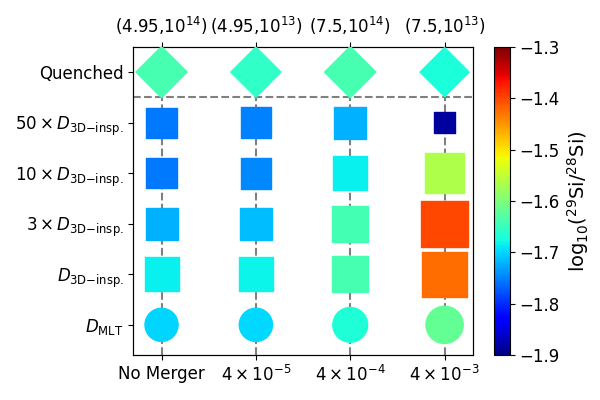

In [80]:
result = comps
cbarlabel = r"$\log_{10}(^{29}\mathrm{Si}/^{28}\mathrm{Si})$"
#cbarlabel = r"$\log_{10}(\mathrm{{{^{40}K}}})$"

ifig=2;plt.close(ifig);
fig,ax=plt.subplots(num=ifig, figsize=(6,4))

min_scale, max_scale = -1.9, -1.3

ax.scatter(xs_full[:4], ys_full[:4], c=get_color(result[:4], min_scale, max_scale), \
                 s=scale_size(result[:4], min_scale, max_scale, min_size=20, max_size=1300, centre=-2), zorder=10)

ax.scatter(xs_full[4:20], ys_full[4:20], c=get_color(result[4:20], min_scale, max_scale), marker='s', \
                 s=scale_size(result[4:20], min_scale, max_scale, min_size=20, max_size=1300, centre=-2), zorder=10)

ax2 = plt.twiny()

ax2.scatter(xs_full[20:], ys_full[20:], c=get_color(result[20:], min_scale, max_scale), marker='D', \
                 s=scale_size(result[20:], min_scale, max_scale, min_size=20, max_size=1300, centre=-2), zorder=10)

ax2.axhline(4.5, color="grey", linestyle='--')

norm, cmap = get_color(0, min_scale, max_scale, get='map')
sm = ScalarMappable(norm=norm, cmap='jet')
sm.set_array([])
cbar = plt.colorbar(sm)
#cbar.set_ticks([-1, -0.5, 0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=12)  # Set tick label font size
cbar.set_label(cbarlabel, fontsize=14)  # Label font size

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels=['No Merger', r'$4\times10^{-5}$',r'$4\times10^{-4}$',r'$4\times10^{-3}$'], fontsize=12)

ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(labels=[r'$D_{\mathrm{MLT}}$',r"$D_{\mathrm{3D{-}insp.}}$",r"$3\times D_{\mathrm{3D{-}insp.}}$",r"$10\times D_{\mathrm{3D{-}insp.}}$",r"$50\times D_{\mathrm{3D{-}insp.}}$", "Quenched"], fontsize=12)

for i in range(4):
    ax.axvline(i, ymin=0,ymax=4.23/5, color='grey', linestyle='--')


ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(labels=[r"(4.95,$10^{14}$)", r"(4.95,$10^{13}$)", r"(7.5,$10^{14}$)", r"(7.5,$10^{13}$)"], fontsize=12)


ax.set_xlim(-0.3,3.3)
ax2.set_xlim(-0.3,3.3)
ax2.set_ylim(-0.6,5.5)
plt.tight_layout()

#plt.savefig(f"../figures/ratio_{ele_of_interest.lower()}.pdf")